In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import Markdown
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.spatial.distance import cdist
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import (
    Pipeline,
    TransformerMixin
)

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold
)

from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [2]:
data_path = Path('../data/raw/data.xls')
dict_path = Path('../data/external/dicionario.csv')

In [3]:
df = (
    pd
    .read_excel(data_path, header=1)
    .rename(columns={
        'default payment next month': 'DEFAULT_PAY'
    })
)
display(Markdown('### Conjunto de dados'))
display(df.head())


df_dict = (
    pd
    .read_csv(dict_path)
    .replace({
        'default payment next month': 'DEFAULT_PAY'
    })
)
display(Markdown('### Dicionário de dados'))
display(df_dict.head())

### Conjunto de dados

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAY
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Dicionário de dados

,variavel,significado,tipo
0,ID,Identificador unico,continuo
1,LIMIT_BAL,Valor do crédito concedido (Novo Dolár Taiwanês ),continuo
2,SEX,Genero (1= masculino; 2= feminino),nominal
3,EDUCATION,Educação Nivel de Escolaridade (1 = pós-gradua...,nominal
4,MARRIAGE,Estado civil (1 = casado; 2 = solteiro; 3 = ou...,nominal


In [4]:
target_column = 'DEFAULT_PAY'
useless_columns = ['ID', target_column]
continuous_columns = (
    df_dict
    .query('tipo == "continuo" and variavel not in @useless_columns')
    .variavel
    .to_list()
)
nominal_columns = (
    df_dict
    .query('tipo == "nominal" and variavel not in @useless_columns')
    .variavel
    .to_list()
)

In [5]:
class OutlierExtractor(TransformerMixin):
    def __init__(self, columns, threshold=3, **kwargs):
        self.threshold = threshold
        self.columns = columns
        self.kwargs = kwargs

    def transform(self, X, y=None):
        X_ = np.asarray(X[self.columns])
        outliers_zscore = np.abs(cdist(self.avg[np.newaxis], X_) / self.std)[0]
        if y is not None:
            y = np.asarray(y)
            return (
                X[outliers_zscore <= self.threshold],
                y[outliers_zscore <= self.threshold]
            )
        
        return X[outliers_zscore <= self.threshold]
    
    def fit(self, X, y=None):
        X = np.asarray(X[self.columns])
        self.std = X.std()
        self.avg = X.mean(axis=0)
        return self

In [6]:
continuous_preprocessor = Pipeline(steps=[
    # ('outlier_extractor', OutlierExtractor(columns = continuous_columns)), # Tratamento de dados discrepantes
    ('missing_data', SimpleImputer(strategy='mean')), # Tratamento de dados faltantes
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=10)), # Seleção de variáveis
    ('normalization', MinMaxScaler()) # Normalização
])

nominal_preprocessor = Pipeline(steps=[
    # Tratamento de dados discrepantes
    ('missing_data', SimpleImputer(strategy='most_frequent')), # Tratamento de dados faltantes
    ('encoder', OneHotEncoder(sparse=False)), # Codificação de variáveis
    # não aplicar seleção apenas 3 variaveis nominais SEX, EDUCATION e MARRIAGE # Seleção de variáveis
    #('normalization', MinMaxScaler())# Normalização 
])

preprocessor = ColumnTransformer(transformers=[
    ('continuous', continuous_preprocessor, continuous_columns),
    ('nominal', nominal_preprocessor, nominal_columns)
])

In [7]:
models = [
    ("logistic regression", LogisticRegression(max_iter=1000)),
    ("support vector machine ", SVC(max_iter=5000)),
    ("k nearest neighbors", KNeighborsClassifier()),
    ("decision tree", DecisionTreeClassifier()),
    ("random forest", RandomForestClassifier()),
    ("mlp", MLPClassifier(max_iter=5000)), 
    ("gaussian naive bayes", GaussianNB())
]

In [8]:
X = df.drop(columns=useless_columns, axis=1)
y = df[target_column]
X = pd.DataFrame(preprocessor.fit_transform(X, y), columns = preprocessor.get_feature_names_out())


X_train, X_both, y_train, y_both = train_test_split(X, y, test_size = 0.5)
X_test, X_val, y_test, y_val = train_test_split(X_both, y_both, test_size = 0.5)


/home/alle/workspace/atlantico/risk-prediction/.venv/lib/python3.8/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [9]:
y_train.value_counts()

0    11658
1     3342
Name: DEFAULT_PAY, dtype: int64

In [10]:
def undersampling(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    x['label'] = y
    x_0 = x[x['label'] == 0]
    x_1 = x[x['label'] == 1]
    x_0 = x_0.sample(n = x_1.shape[0])
    x = pd.concat([x_0, x_1], ignore_index=True, axis=0).sample(frac=1)
    return x.drop('label', axis=1), x['label']

In [11]:
X_train2, y_train2 = undersampling(X_train, y_train)

In [12]:
y_train2.value_counts()

1    3342
0    3342
Name: label, dtype: int64

In [13]:
def conf_matrix(y_test, predicted):
    cm = confusion_matrix(y_test, predicted)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm
    )
    disp.plot()
    plt.show()

In [14]:
def train_model(x,y,X_val, y_val, n_splits=10, final_results = {}):
    for model_name, model_obj in models:
        results = cross_validate(
            model_obj,
            X=x,
            y=y,
            scoring=['accuracy', 'f1', 'recall', 'precision'],
            cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42),
            n_jobs=-1
        )
        results["name"] = [model_name] * n_splits

        clf = model_obj.fit(x, y)
        y_pred = model_obj.predict(X_val)
        
        print("=======================================")
        print(model_name)
        conf_matrix(y_val, y_pred)
        
        if final_results:
            for key, value in results.items():
                final_results[key] = np.append(final_results[key], value)
        else:
            final_results = results
    return final_results
    

logistic regression


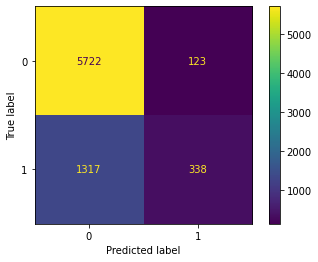

/home/alle/workspace/atlantico/risk-prediction/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


support vector machine 


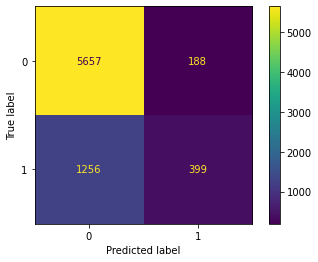

/home/alle/workspace/atlantico/risk-prediction/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k nearest neighbors


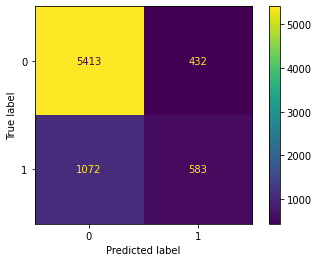

decision tree


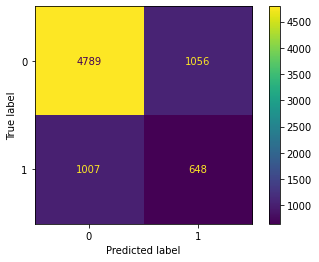

random forest


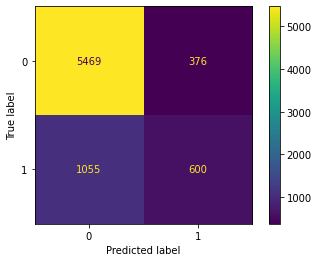

mlp


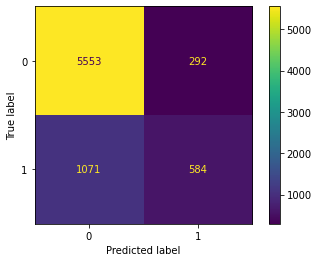

gaussian naive bayes


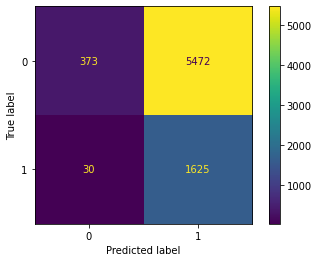

In [15]:
final_results = train_model(X_train.drop('label', axis=1),y_train,X_val,y_val) ## Dados desbalanceados para a classe 0

logistic regression


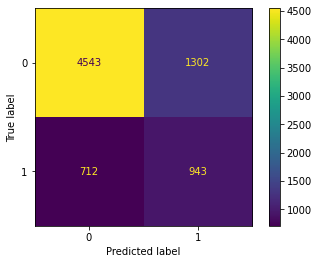

support vector machine 


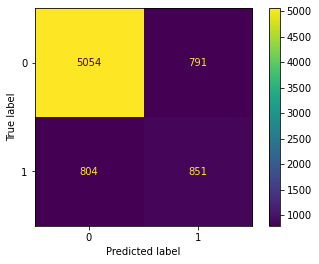

/home/alle/workspace/atlantico/risk-prediction/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k nearest neighbors


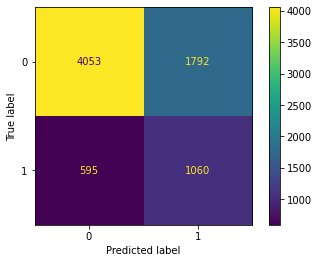

decision tree


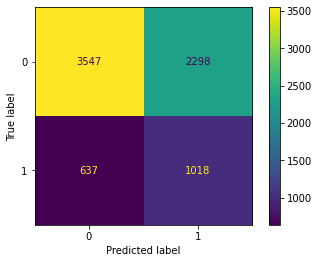

random forest


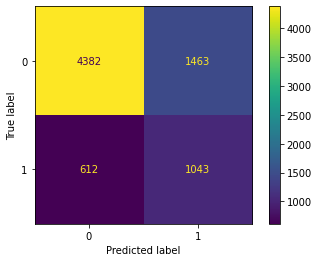

mlp


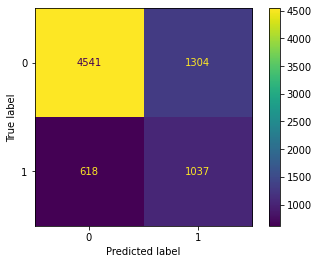

gaussian naive bayes


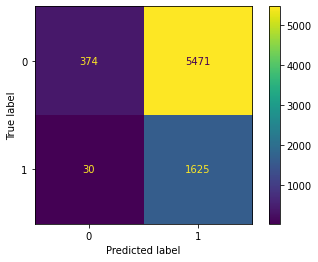

In [16]:
final_results2 = train_model(X_train2,y_train2,X_val,y_val) ## Dados balanceados

In [17]:
pd.DataFrame(final_results).groupby('name').agg([np.mean, np.std])

fit_time           score_time            \
                              mean       std       mean       std   
name                                                                
decision tree             0.237805  0.006137   0.012930  0.000659   
gaussian naive bayes      0.020177  0.002366   0.015476  0.001726   
k nearest neighbors       0.009058  0.002453   0.460772  0.026075   
logistic regression       0.458001  0.030714   0.013147  0.000713   
mlp                      27.723254  5.922767   0.017809  0.003144   
random forest             3.540704  0.251022   0.108823  0.005017   
support vector machine   14.368792  0.545329   1.138527  0.028703   

                        test_accuracy             test_f1            \
                                 mean       std      mean       std   
name                                                                  
decision tree                0.731600  0.010189  0.399706  0.023897   
gaussian naive bayes         0.268867  0.007813  0.372855  0.003832   
k nearest neighbors          0.797933  0.008500  0.444789  0.020862   
logistic regression          0.807600  0.004901  0.342606  0.025344   
mlp                          0.815800  0.010366  0.471883  0.041271   
random forest                0.811600  0.008995  0.472145  0.022880   
support vector machine       0.806467  0.006741  0.363058  0.016161   

                        test_recall           test_precision            
                               mean       std           mean       std  
name                                                                    
decision tree              0.401273  0.027322       0.398344  0.022155  
gaussian naive bayes       0.975463  0.010450       0.230479  0.002530  
k nearest neighbors        0.363269  0.018090       0.574015  0.030451  
logistic regression        0.225607  0.023256       0.720916  0.048127  
mlp                        0.371033  0.045124       0.653098  0.041278  
random forest              0.378220  0.020663       0.629431  0.037617  
support vector machine     0.247748  0.016174       0.686311  0.059381

In [18]:
pd.DataFrame(final_results2).groupby('name').agg([np.mean, np.std])

fit_time           score_time            \
                              mean       std       mean       std   
name                                                                
decision tree             0.085179  0.005077   0.011472  0.001148   
gaussian naive bayes      0.011898  0.001333   0.011704  0.000808   
k nearest neighbors       0.006042  0.000959   0.123831  0.004772   
logistic regression       0.210138  0.015735   0.012171  0.002041   
mlp                      14.907597  2.548737   0.011942  0.000307   
random forest             1.507133  0.026924   0.067160  0.005601   
support vector machine    4.147006  0.207021   0.412542  0.020704   

                        test_accuracy             test_f1            \
                                 mean       std      mean       std   
name                                                                  
decision tree                0.618639  0.022870  0.619794  0.019999   
gaussian naive bayes         0.526033  0.008402  0.671713  0.004547   
k nearest neighbors          0.666674  0.021053  0.658684  0.022679   
logistic regression          0.680731  0.017067  0.648092  0.020214   
mlp                          0.700183  0.014960  0.665535  0.018049   
random forest                0.691657  0.019712  0.675911  0.021290   
support vector machine       0.691807  0.014962  0.628133  0.018269   

                        test_recall           test_precision            
                               mean       std           mean       std  
name                                                                    
decision tree              0.621472  0.020592       0.618499  0.024975  
gaussian naive bayes       0.970071  0.027117       0.513933  0.005246  
k nearest neighbors        0.643637  0.028824       0.674941  0.022737  
logistic regression        0.588256  0.023145       0.721911  0.022021  
mlp                        0.596938  0.023957       0.752933  0.023865  
random forest              0.643321  0.025676       0.712444  0.023425  
support vector machine     0.520646  0.017084       0.791941  0.025575